In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import interest_rates_DV01_risk as ir

/home/cmileto/miniforge3/envs/monte/lib/python3.11/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
tenors = ['1y', '2y', '5y', '10y', '15y', '30y']
    
# Créer le générateur de paramètres avec un taux de base personnalisé
param_generator = ir.RateModelParametersGenerator(
    tenors=tenors,
    base_rate=2.5,  # Taux de base plus bas
    curve_steepness=0.6,  # Courbe plus pentue
    vol_level=0.9,  # Volatilité de base plus élevée
    vol_decay=0.2,  # Décroissance plus rapide des volatilités
    corr_decay=0.1  # Décroissance plus lente des corrélations
)

Taux d'intérêt initiaux (%)
  1y: 2.92
  2y: 3.16
  5y: 3.58
  10y: 3.94
  15y: 4.16
  30y: 4.56

Volatilités annualisées (%)
  1y: 0.82
  2y: 0.76
  5y: 0.65
  10y: 0.54
  15y: 0.47
  30y: 0.35

Matrice de corrélation
       1y    2y    5y   10y   15y   30y
1y   1.00  0.90  0.67  0.41  0.25  0.06
2y   0.90  1.00  0.74  0.45  0.27  0.06
5y   0.67  0.74  1.00  0.61  0.37  0.08
10y  0.41  0.45  0.61  1.00  0.61  0.14
15y  0.25  0.27  0.37  0.61  1.00  0.22
30y  0.06  0.06  0.08  0.14  0.22  1.00


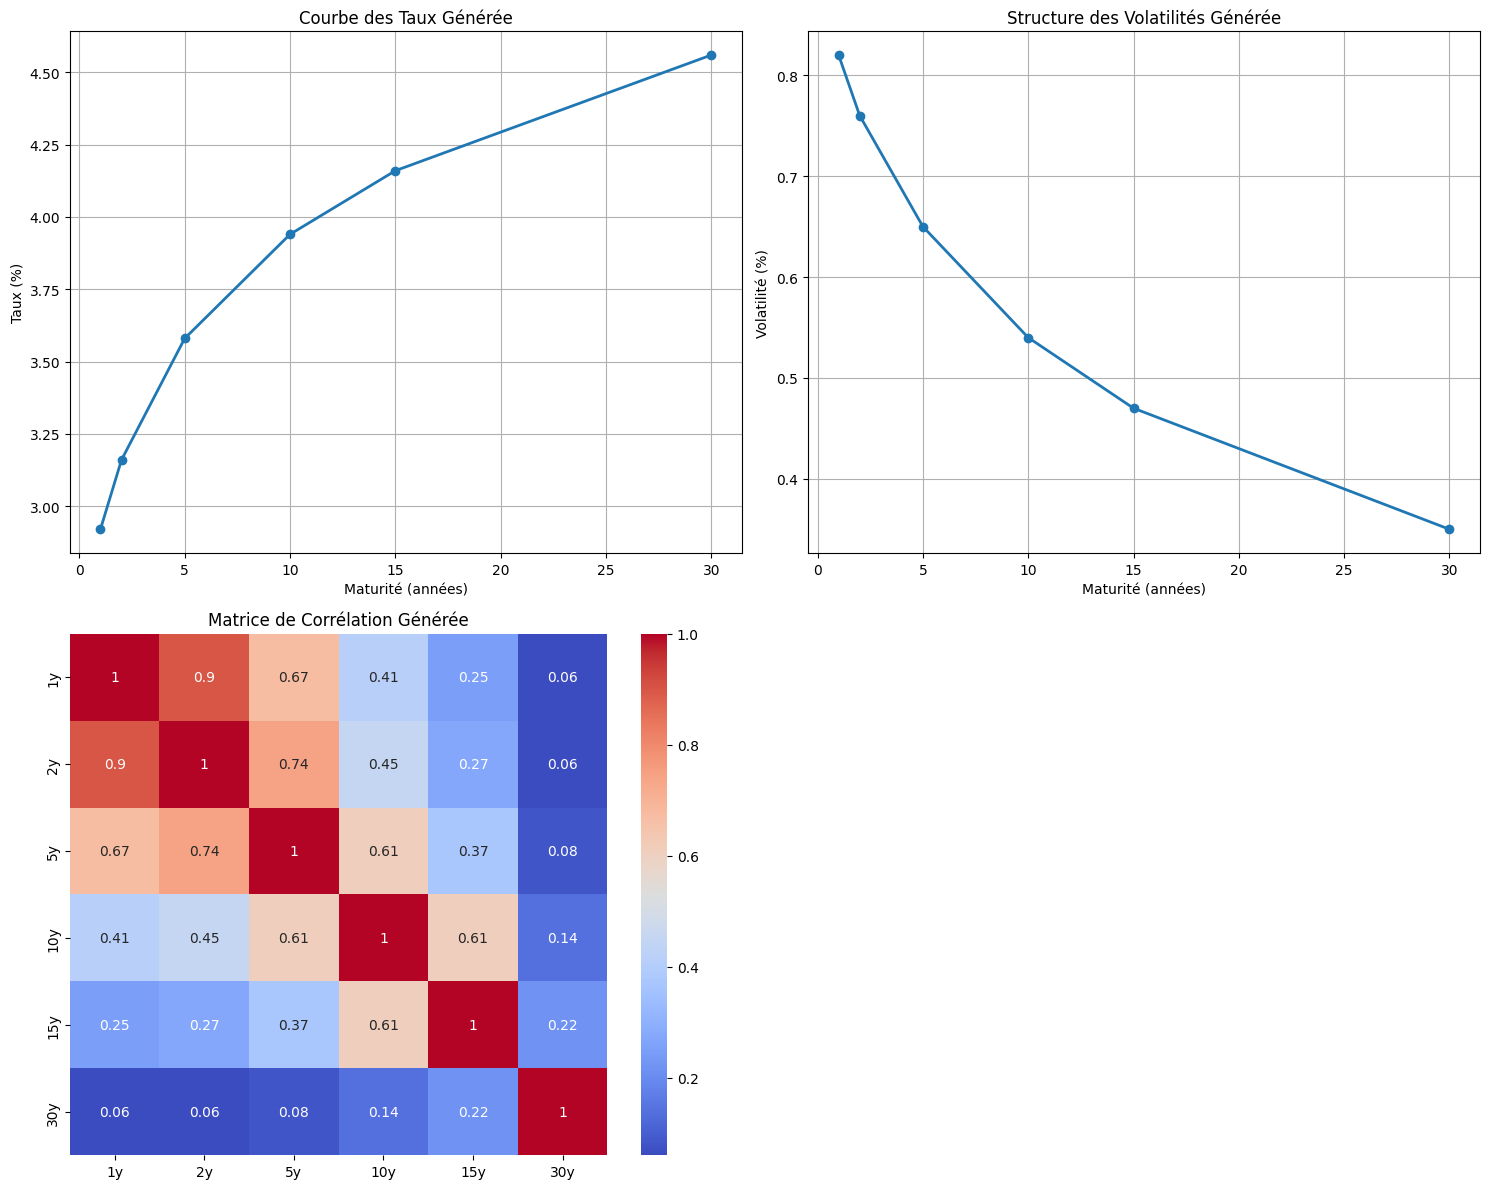

In [3]:
# Afficher et visualiser tous les paramètres
initial_rates, volatilities, correlations = param_generator.display_all_parameters()

In [4]:
# Utiliser ces paramètres dans le simulateur de trajectoires
mean_reversion = 0.05  # Paramètre de retour à la moyenne

# Initialiser le simulateur
sim = ir.InterestRatePathSimulator(initial_rates, volatilities, correlations, mean_reversion)

In [5]:
# Simuler les trajectoires pour 20 périodes, 50 simulations
n_periods = 20
n_simulations = 50
paths = sim.simulate_paths(n_periods, n_simulations, dt=1/12)  # dt mensuel

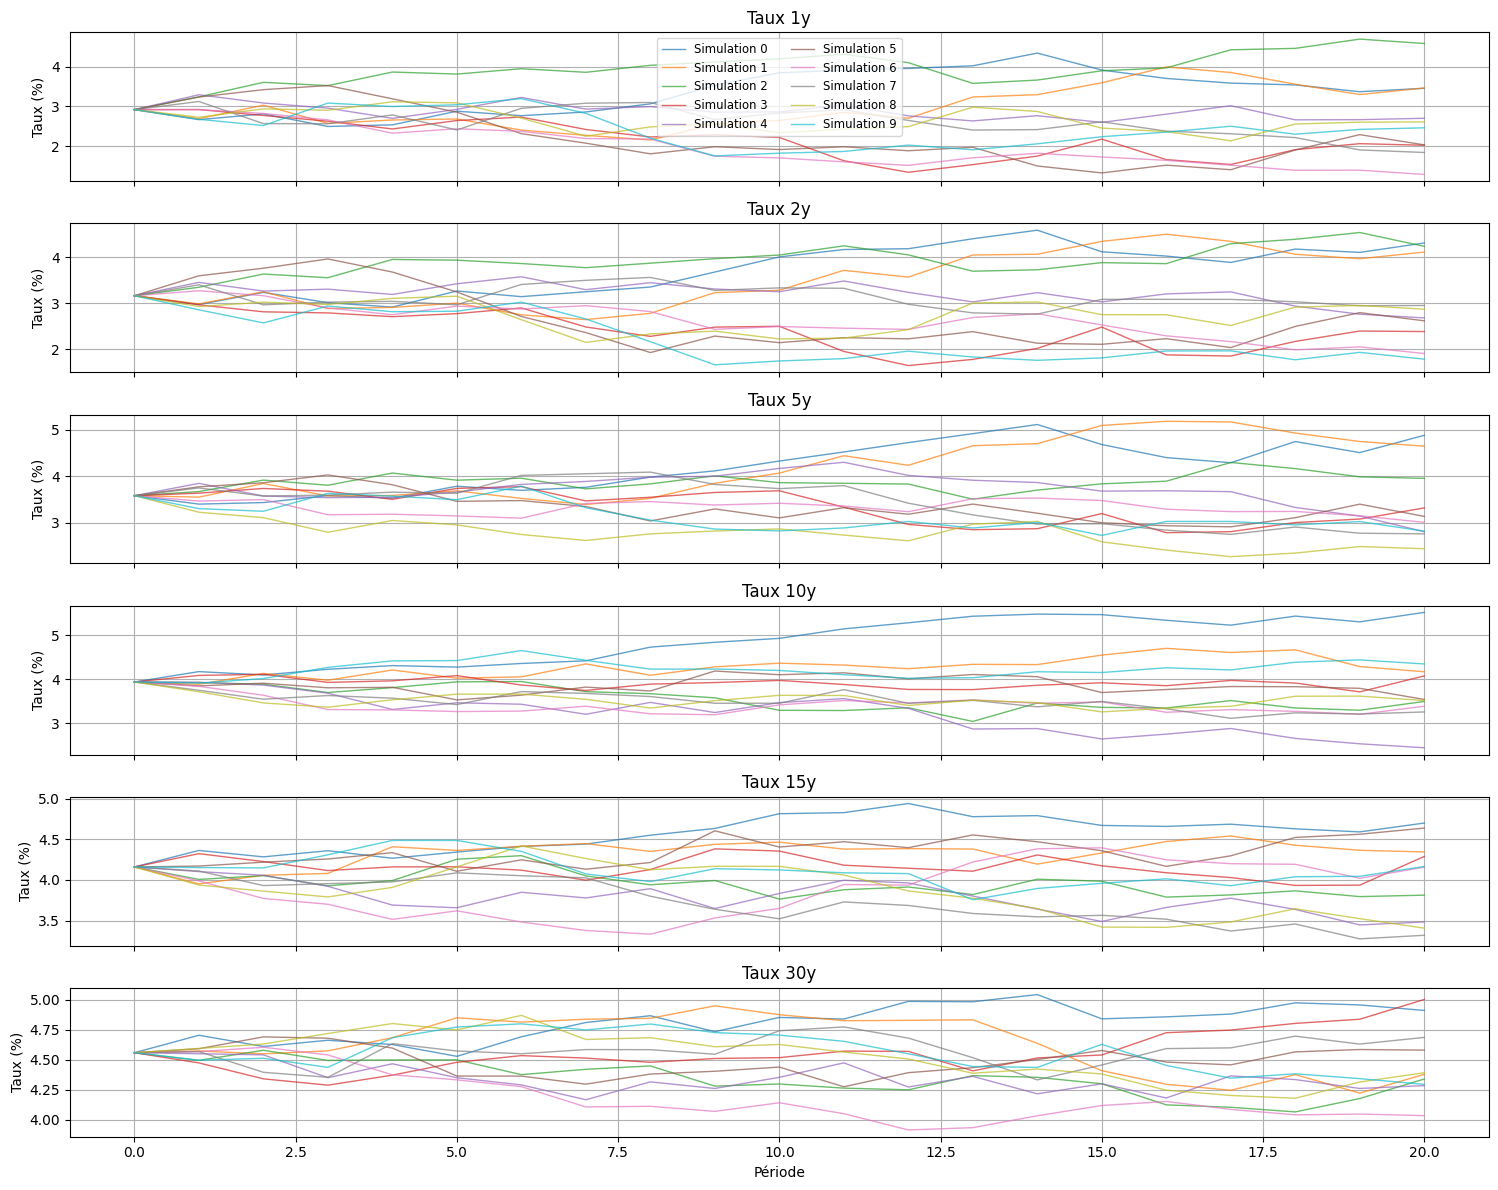

In [6]:
 # Visualiser quelques trajectoires
sim.plot_simulated_paths(paths, simulation_indices=range(10))

In [7]:
# Créer un portefeuille d'obligations simplifié
# Pour commencer, utilisons seulement le DV01 global

bonds_df = pd.DataFrame({
    'name': ['Bon du Trésor 2Y', 'Obligation Corp 5Y', 'Obligation État 10Y'],
    'face_value': [1000000, 500000, 2000000],  # Valeur nominale
    'maturity': [2, 5, 10],  # Maturité en années
    'coupon': [0.02, 0.04, 0.03],  # Taux du coupon annuel
    'dv01': [190, 430, 870]  # DV01 global en dollars pour un mouvement de 1bp
})

# Configuration simple: simulation avec un seul facteur de risque
rate_mean = 0.0    # Moyenne de variation des taux (0 = pas de dérive)
rate_std = 0.0015  # Écart-type de 15 points de base par jour

In [8]:
# Créer et exécuter la simulation
sim = ir.InterestRateRiskMonteCarlo(bonds_df, rate_mean, rate_std)
results = sim.simulate_portfolio(10000)  # 10,000 simulations

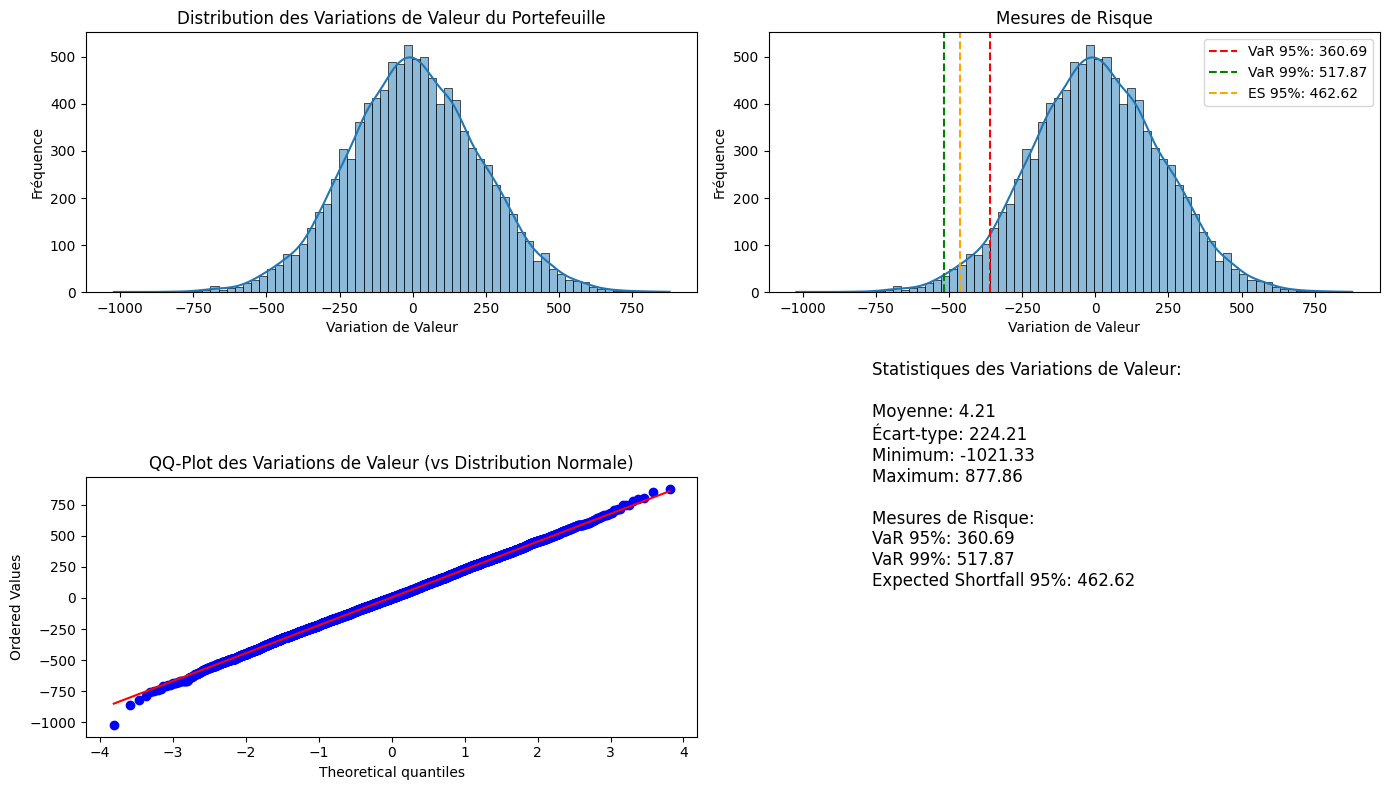


Résultats de la simulation:
VaR_95: 360.69
VaR_99: 517.87
ES_95: 462.62
mean_change: 4.21
std_dev: 224.21


In [12]:
# Afficher les résultats
risk_metrics = sim.plot_results()
print("\nRésultats de la simulation:")
for metric, value in risk_metrics.items():
    print(f"{metric}: {value:,.2f}")

In [13]:
# Exemple plus avancé avec Partial 01s / Key Rate Duration
# Définir les points de la courbe des taux (tenors)
tenors = ['3m', '1y', '2y', '5y', '10y']

# Créer un exemple de portefeuille avec Partial 01s
bonds_advanced_df = pd.DataFrame({
    'name': ['Obligation A', 'Obligation B', 'Obligation C'],
    'face_value': [1000000, 1500000, 2000000],
    'maturity': [2, 5, 10],
    'coupon': [0.02, 0.025, 0.03],
    'dv01': [190, 430, 870],
    # Partial 01s (sensibilité à chaque point de la courbe en dollars pour 1bp)
    'partial_01s': [
        {'3m': 20, '1y': 70, '2y': 100, '5y': 0, '10y': 0},
        {'3m': 10, '1y': 20, '2y': 50, '5y': 350, '10y': 0},
        {'3m': 5, '1y': 15, '2y': 30, '5y': 70, '10y': 750}
    ]
})

# Définir les paramètres pour chaque point de la courbe
rate_means = np.zeros(len(tenors))  # Pas de dérive
rate_stds = np.array([0.0010, 0.0012, 0.0013, 0.0015, 0.0012])  # Volatilités par tenor

# Matrice de corrélation entre les points de la courbe (simplifiée et garantie définie positive)
corr_matrix = np.array([
    [1.00, 0.80, 0.60, 0.40, 0.20],
    [0.80, 1.00, 0.80, 0.60, 0.40],
    [0.60, 0.80, 1.00, 0.80, 0.60],
    [0.40, 0.60, 0.80, 1.00, 0.80],
    [0.20, 0.40, 0.60, 0.80, 1.00]
])

# Vérifier que la matrice est définie positive avant de procéder
eigenvalues = np.linalg.eigvalsh(corr_matrix)
print("Valeurs propres de la matrice de corrélation:", eigenvalues)
if np.all(eigenvalues > 0):
    print("La matrice est définie positive, on peut procéder.")
else:
    print("Attention: La matrice n'est pas définie positive.")

Valeurs propres de la matrice de corrélation: [0.10968632 0.1527864  0.25475415 1.0472136  3.43555952]
La matrice est définie positive, on peut procéder.


In [15]:
# Si tout est bon, créer et exécuter la simulation avancée
sim_advanced = ir.InterestRateRiskMonteCarlo(bonds_advanced_df, rate_means, rate_stds, corr_matrix)
results_advanced = sim_advanced.simulate_portfolio(10000)

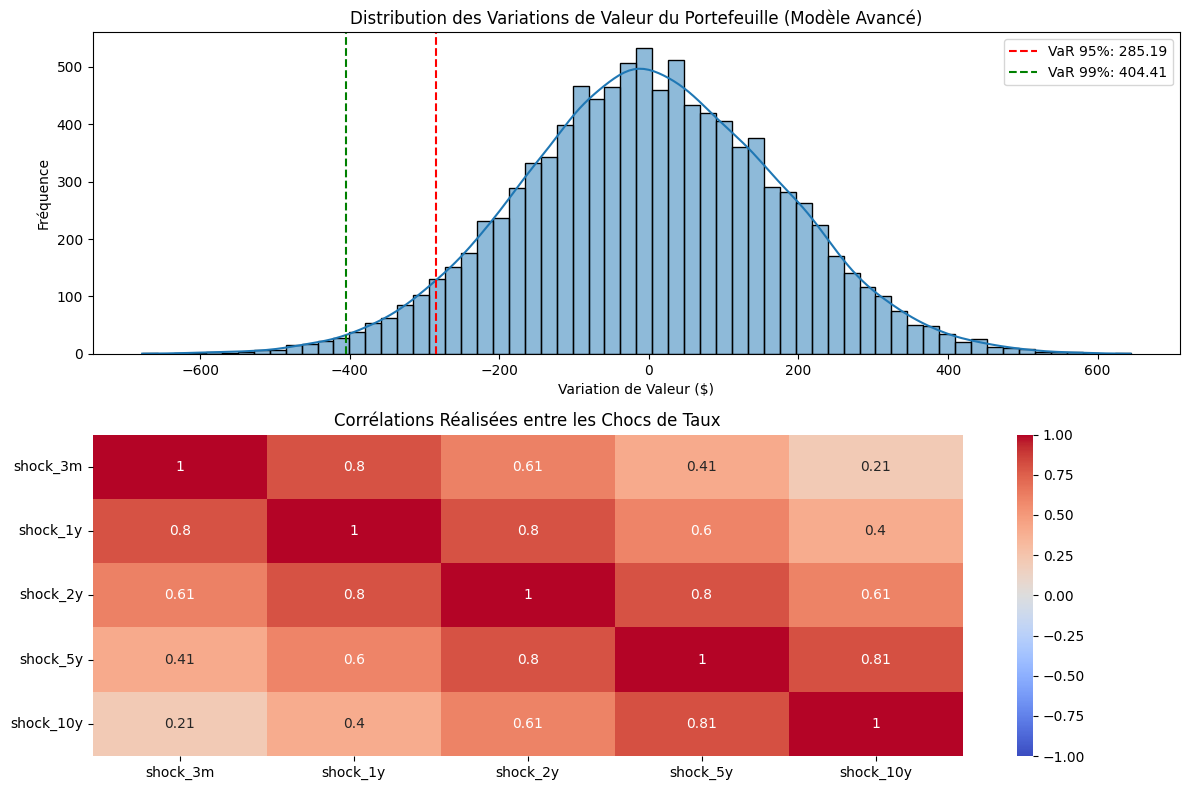

In [16]:
# Visualiser les résultats
plt.figure(figsize=(12, 8))

# Distribution des variations de valeur
plt.subplot(2, 1, 1)
sns.histplot(results_advanced['value_change'], kde=True)
var_95 = np.percentile(results_advanced['value_change'], 5)
var_99 = np.percentile(results_advanced['value_change'], 1)
plt.axvline(x=var_95, color='r', linestyle='--', label=f'VaR 95%: {-var_95:.2f}')
plt.axvline(x=var_99, color='g', linestyle='--', label=f'VaR 99%: {-var_99:.2f}')
plt.title('Distribution des Variations de Valeur du Portefeuille (Modèle Avancé)')
plt.xlabel('Variation de Valeur ($)')
plt.ylabel('Fréquence')
plt.legend()

# Heatmap des corrélations entre les chocs de taux
plt.subplot(2, 1, 2)
shocks_cols = [col for col in results_advanced.columns if col.startswith('shock_')]
shocks_df = results_advanced[shocks_cols]
shocks_corr = shocks_df.corr()
sns.heatmap(shocks_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Corrélations Réalisées entre les Chocs de Taux')

plt.tight_layout()
plt.show()

In [18]:
# Stress testing avec quelques scénarios simples
stress_scenarios = {
    'Hausse parallèle +1%': np.ones(len(tenors)) * 0.01,
    'Pentification +1%': np.linspace(0.001, 0.01, len(tenors)),
    'Inversion -1%': np.linspace(0.01, 0.001, len(tenors)),
    'Choc court terme': np.array([0.015, 0.01, 0.005, 0.002, 0.001])
}

In [19]:
# Calculer l'impact des scénarios de stress
stress_results = []
for name, shocks in stress_scenarios.items():
    value_change = sim_advanced.calculate_portfolio_value_change(shocks)
    stress_results.append({'Scénario': name, 'Variation de valeur': value_change})

In [20]:

stress_df = pd.DataFrame(stress_results)
print("\nRésultats du stress testing:")
print(stress_df)


Résultats du stress testing:
               Scénario  Variation de valeur
0  Hausse parallèle +1%            -1490.000
1     Pentification +1%            -1212.125
2         Inversion -1%             -426.875
3      Choc court terme             -406.500


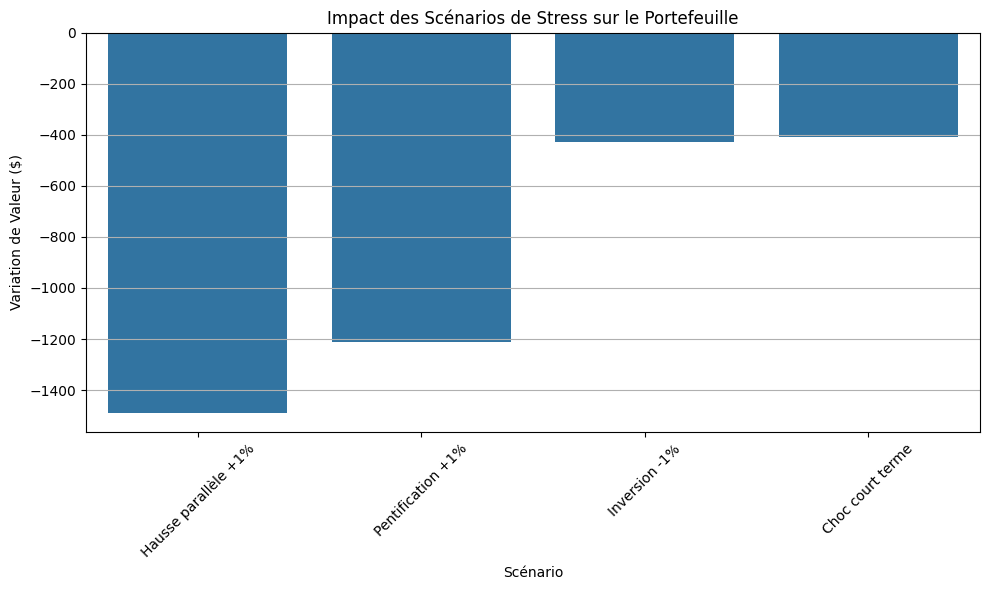

In [21]:
# Visualiser les résultats du stress testing
plt.figure(figsize=(10, 6))
sns.barplot(x='Scénario', y='Variation de valeur', data=stress_df)
plt.title('Impact des Scénarios de Stress sur le Portefeuille')
plt.ylabel('Variation de Valeur ($)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()